### Importing Libraries

In [45]:
#Importing libraries
import pandas as pd
import numpy as np
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD  #;'Single Value Decomposition'
from surprise.accuracy import rmse, mae

### Importing Data

Using open source dataset from GroupLens Research (movielens.org)

In [46]:
df = pd.read_csv('downloads/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [47]:
#Dropping Timestamp
df.drop('timestamp',axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Checking for Missing Data

In [48]:
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

No missing data found

### EDA (Exploratory Data Analysis)

Analyzing dataset to get main characteristics.

#### No. of Unique users and movies

In [49]:
movies = df['movieId'].nunique()
users = df['userId'].nunique()
print(f'No. of unique movies in dataset: {movies}')
print(f'No. of unique users in dataset: {users}')

No. of unique movies in dataset: 9724
No. of unique users in dataset: 610


#### Sparsity of data
sparsity(%) = # missing values/ total values *100

In [50]:
avail_ratings = df['rating'].count()
total_ratings = movies*users
missing_ratings = total_ratings - avail_ratings
sparsity = (missing_ratings/total_ratings)*100
print(f'Sparsity: {sparsity}')


Sparsity: 98.30003169443864


#### Ratings Distribution

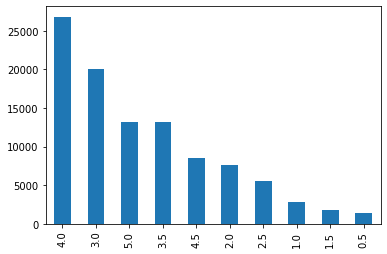

In [51]:
df['rating'].value_counts().plot(kind = 'bar')

Maximum rating given by user is 5 and minimum is 0.5. and frequency of rating 4 is maximum that means rating 4 is given maxmium number of time.

### Dimensionality Reduction

To reduce the dimensionality of the dataset, filter out rarely rated movies and rarely rating users

In [52]:
# Filter movies with less than 3 ratings

filter_movies = df['movieId'].value_counts() > 3
# true if rated more than 3 times
#no. of times particular movie was rated

filter_movies = filter_movies[filter_movies].index.tolist()

In [53]:
# Filter users with less than 3 ratings
filter_users = df['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()

In [54]:
print(f'Original shape: {df.shape} ')
# Remove the filtered one out of the dataframe
df = df[(df['movieId'].isin(filter_movies)) &
        (df['userId'].isin(filter_users))]
print(f'New shape:{df.shape}')


Original shape: (100836, 3) 
New shape:(92394, 3)


### Create Training and Test sets

In [55]:
# Columns used for training 
cols = ['userId', 'movieId', 'rating']

In [56]:
#Create surprise dataset
reader = Reader(rating_scale = (0.5, 5)) 
#helps in prediction 
data =Dataset.load_from_df(df[cols],reader)

In [57]:
#Create train set and Prediction set
# To train we used complete dataset
trainset = data.build_full_trainset()


# antiset contains rating that are missing (pairs)
# To predict we will use antiset
antiset = trainset.build_anti_testset()


### Creating the Model

SVD

Interaction matrix = A X B X C

In [58]:
# each row = user
# each colm = items
# elements = rating given to items by user
# SVD reduces the matrix into its component parts
# 1st factorize the interaction matrix and 
        #then multiply back to get complete matrix close to interaction matrix

model = SVD(n_epochs = 25, verbose = True)

### Training the Model

In [60]:
# Cross validation - > Resampling procedure used to evaluate ML model
# Divide the data into k parts and take k-1 part to train and 1 part to test.
    #and will repeat it k = 5 times with different set.

#RMSE root mean sq error and MAE mean absolute error
cross_validate(model , data , measures = ['RMSE', 'MAE'],
               cv = 5, verbose = False)
print('>>Training completed')


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

### Prediction

#### Predicting ratings for all pairs (user, items) that are NOT in the training set

In [61]:
predictions = model.test(antiset)

In [62]:
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=5, details={'was_impossible': False})

user 1 will rate the t=movie 318 ->5 that mean we should recommend this movie to this user.
r_ui ->real rating (avg rating), prediction was possible if impossible we won't be able to predict for that user.

### Recommending top 3 movies based on predictions

In [66]:
# store the prediction for each user using dictionary
from collections import defaultdict

def get_top_n(predictions, n):
    top_n = defaultdict(list)  #key user id
    for uid, iid, _ ,est ,_ in predictions:
        top_n[uid].append((iid, est)) #x[1] = est
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True) 
            #key for sorting is estimate est
        top_n[uid] = user_ratings[:n]
    return top_n
    pass

top_n = get_top_n(predictions, n=3)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, rating) in user_ratings] )

1 [318, 58559, 1272]
2 [1104, 2959, 1262]
3 [3147, 246, 741]
4 [1104, 5995, 1041]
5 [68954, 7361, 3451]
6 [3916, 3275, 2762]
7 [1136, 1193, 1233]
8 [750, 68954, 92259]
9 [1089, 1136, 858]
10 [1233, 3213, 105504]
11 [1233, 912, 1196]
12 [110, 260, 356]
13 [296, 858, 527]
14 [1225, 1206, 2324]
15 [110, 1228, 1221]
16 [1233, 908, 1237]
17 [92259, 3275, 38061]
18 [1204, 1283, 912]
19 [858, 110, 750]
20 [260, 1196, 318]
21 [1172, 81847, 44195]
22 [296, 1220, 1217]
23 [1197, 110, 2959]
24 [1235, 1204, 1206]
25 [101, 356, 593]
26 [750, 2959, 260]
27 [296, 2324, 44555]
28 [1252, 246, 1967]
29 [1193, 1221, 260]
30 [527, 1136, 1197]
31 [750, 1250, 7361]
32 [750, 2959, 4973]
33 [4973, 80906, 904]
34 [3147, 457, 1278]
35 [356, 1217, 5995]
36 [858, 1233, 68157]
37 [3451, 1262, 750]
38 [56782, 1242, 3275]
39 [527, 7361, 1206]
40 [1104, 58559, 1228]
41 [1233, 3451, 1237]
42 [81847, 608, 1237]
43 [6, 50, 223]
44 [1193, 318, 46578]
45 [904, 3275, 44191]
46 [2959, 356, 1089]
47 [527, 2318, 1237]
48 [295